# Program für Roboter- und Computervision

## Importieren der Bibliotheken

In [575]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
# for Rotation only cutting the picture
import argparse
import pydash
import random
import imutils as im
import csv
import sqlite3
import tensorflow as tf
import gzip
import struct
import os

## Parameters

In [576]:
imagePath = "./Briefe/Brief_rotated150.jpg"
# Kernel
blurring = 0
dilateErode = 1
dilateKernel = np.ones((dilateErode,dilateErode), "uint8")
erodeKernel = np.ones((dilateErode,dilateErode), "uint8")
# CharacterKernel
characterDilateErode = 11
characterDK = np.ones((characterDilateErode,characterDilateErode),"uint8")
characterEK = np.ones((characterDilateErode,characterDilateErode),"uint8")

 
# C5/6 Scale  220x110
C_5_6_Metrics= [220,110]
C_5_6_Scale = [1.8,2.4]
stampZone = [74,40]
margin = 15
stampMinSize=[28,15]

## Vorbereitung des Bildes

<img src="./README_pictures/Normen_Brief.png"/>

Text(0.5, 1.0, 'Original')

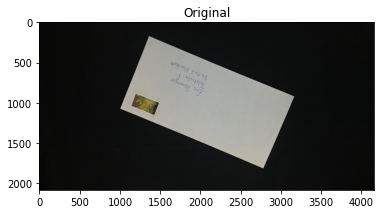

In [577]:
    # Lesen des Bilds
image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
if image is None:
      raise SystemExit("Imagepath is not right")
height,width,channels = image.shape
height-=1
width-=1
showImage = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # Zeigen des Bilds
plt.imshow(showImage)
plt.title("Original")

## For Rotating the Picture
https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/

Text(0.5, 1.0, 'blurred')

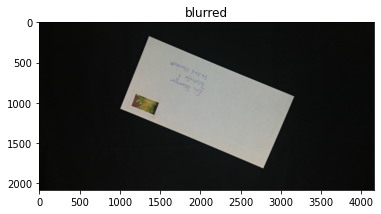

In [578]:
    # Gausian Blur
blurred  = cv2.GaussianBlur(image, (blurring,blurring) , 2, 2,cv2.THRESH_BINARY)
blurredShow = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)
plt.imshow(blurredShow)
plt.title("blurred")

## Binarisierung
https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-3-otsu-thresholding/

Text(0.5, 1.0, 'Gray')

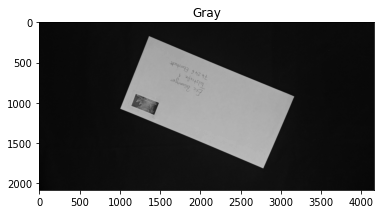

In [579]:
# thresh1 = cv2.adaptiveThreshold(blurred,255,125,cv2.THRESH_BINARY,11,5)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) 
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
plt.title("Gray")

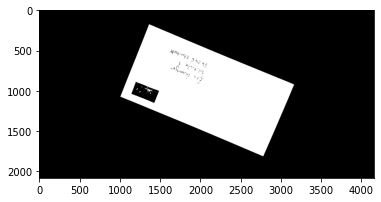

In [580]:
th,binImg  = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
plt.imshow(binImg,cmap="gray")

Text(0.5, 1.0, 'dilate')

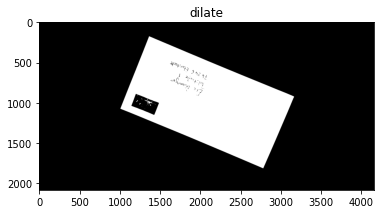

In [581]:
erode = cv2.erode(binImg,erodeKernel,iterations=1)
plt.imshow(erode, cmap="gray")
plt.title("dilate")

Text(0.5, 1.0, 'erode')

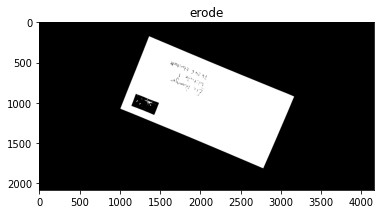

In [582]:
dilate = cv2.dilate(erode,dilateKernel,iterations=1)
plt.imshow(dilate, cmap="gray")
plt.title("erode")

Text(0.5, 1.0, 'Canny')

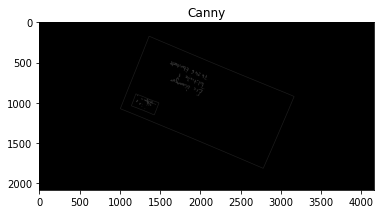

In [583]:
canny = cv2.Canny(dilate,0,30)
height,width = canny.shape
plt.imshow(canny, cmap="gray")
plt.title("Canny")

In [584]:
def align_straight(image):
    img,contours,hierachies = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for index,hierachy in enumerate(hierachies):
        hNext, hPrev, hChild, hParent = hierachy[0]
        if (hChild != -1) and (hParent == -1):      #Extract Parent contour
            contour = contours[0][index]
    center,[letter_W,letter_H],angle = cv2.minAreaRect(contours[1])
    print (center,[letter_W,letter_H],angle)
    if letter_W < letter_H:
        aligned_image = im.rotate_bound(image,-angle+90)
    else:
        aligned_image = im.rotate_bound(image,-angle)
    return aligned_image  

(2081.748046875, 993.9598388671875) [970.4188232421875, 1951.53662109375] -67.40593719482422


Text(0.5, 1.0, 'straight-aligned')

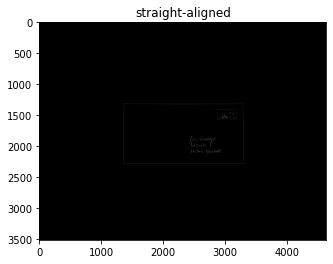

In [585]:
aligned_image = align_straight(canny)
plt.imshow(aligned_image,cmap="gray")
plt.title("straight-aligned")

In [586]:
img,contours,hierachy = cv2.findContours(aligned_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
# Hierarchie [Previous, Next, Child, Parent]

In [587]:
def sizeSort(element):
    return len(element)
contours.sort(reverse=True,key=sizeSort)
# Print the 5 biggest Contoursizes
for index,contour in enumerate(contours):
    if(index<6):
        print(contour.size)

11608
11590
1862
1860
474
464


## Get the Moments
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [588]:
# https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
def findLetter(contours):
    letter ={}
    for i,contour in enumerate(contours):
    #( center (x,y), (width, height), angle of rotation ).
        minArea = cv2.minAreaRect(contour)
        width = minArea[1][0]
        height = minArea[1][1]
        scale = width/height
        print("Contour: "+ str(i)+ " / scale: "+ str(scale) + " / width: " + str(width) + " / height:" + str(height))
        if(scale>C_5_6_Scale[0] and scale<C_5_6_Scale[1]):
            letter = {
                "width": int(width),
                "height" : int(height),
                "centerX" : int(minArea[0][0]),
                "centerY" : int(minArea[0][1]),
                "contour": contour
                }
            return letter

Contour: 0 / scale: 2.009259259259259 / width: 1953.0 / height:972.0


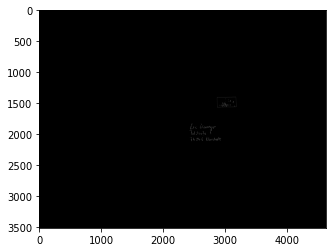

In [589]:
letterValue = findLetter(contours)
if letterValue is None:
      raise SystemExit("letter not found")
# Highlight the Contour of Find Letter and show center of Letter
highlightedContour = aligned_image.copy()
highlightedContour = cv2.circle(highlightedContour,(letterValue["centerX"],letterValue["centerY"]),radius=30, color=(0,0,255),thickness=-1)
cv2.drawContours(highlightedContour, letterValue["contour"], -1, (0, 0, 255), 20) 
plt.imshow(highlightedContour)

## ROI of Letter

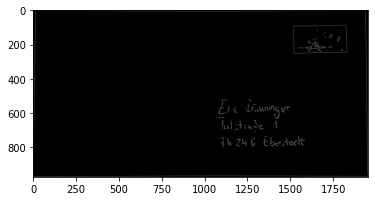

In [590]:
xStart = int(letterValue["centerX"]-letterValue["width"]/2)
xEnd = int(letterValue["centerX"]+letterValue["width"]/2)
yStart = int(letterValue["centerY"]-letterValue["height"]/2)
yEnd = int(letterValue["centerY"]+letterValue["height"]/2)
letter =aligned_image[yStart:yEnd,xStart:xEnd]
plt.imshow(letter, cmap="gray")

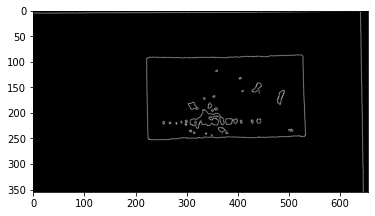

In [591]:
pixelPerMM = letterValue["width"]/C_5_6_Metrics[0]
# StampZone [width, height] amount of Pixel
stampZoneMetrics = [int(stampZone[0]*pixelPerMM),int(stampZone[1]*pixelPerMM)]
# get the rigth Top StampZone
rightTop = letter[0:stampZoneMetrics[1],letterValue["width"]-stampZoneMetrics[0]:letterValue["width"]]
plt.imshow(rightTop, cmap="gray")

### Check if stamp is there

In [592]:
def checkStamp(stampZone, pixelPerMM):
    stamp_found = False
    imgStamp,cStamp,hStamp = cv2.findContours(stampZone,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    if (len(cStamp)!=0):                #No contour found
        for index,contour in enumerate(cStamp):         
            #( center (x,y), (width, height), angle of rotation ).
            hNext, hPrev, hChild, hParent = hStamp[0][index]
            if (hChild != -1) and (hParent == -1):      #Extract Parent contour
                #TBD: If there are some contours beside the stemp the first and/or second condition would be FALSE...
                minArea = cv2.minAreaRect(contour)
                width = minArea[1][0]
                height = minArea[1][1]
                # stamp minSize 22x28
                contourWidth = width/pixelPerMM
                contourHeigth = height/pixelPerMM
                if((contourWidth >= stampMinSize[0]) and (contourHeigth >= stampMinSize[1])):
                    stamp_found = True
                else:
                    stamp_found = False
    return stamp_found

def align_correct(roiLetter,pixelPerMM):
    # StampZone [width, height] amount of Pixel
    stampZoneMetrics = [int(stampZone[0]*pixelPerMM),int(stampZone[1]*pixelPerMM)]
    # get the rigth Top StampZone
    rightTop = roiLetter[0:stampZoneMetrics[1],letterValue["width"]-stampZoneMetrics[0]:letterValue["width"]]
    stamp_found = checkStamp(rightTop,pixelPerMM)      
    if stamp_found:
        return roiLetter
    else:
        return im.rotate_bound(roiLetter,180)


Text(0.5, 1.0, 'correct-aligned')

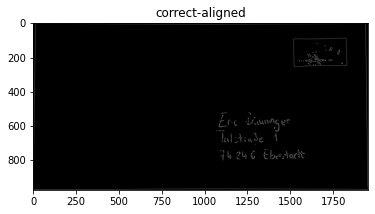

In [593]:
correct_aligned = align_correct(letter, pixelPerMM)
plt.imshow(correct_aligned, cmap ="gray")
plt.title("correct-aligned")

## Get AddressField

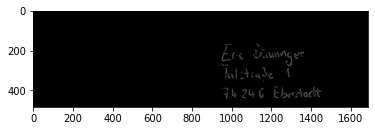

In [594]:
height, width = letter.shape
pixelMargin = margin*pixelPerMM
addressField = letter.copy()
startX = int(pixelMargin)
endX = int(width-pixelMargin)
startY = int(stampZone[1]*pixelPerMM)
endY = int(height-pixelMargin)
addressField = addressField[startY:endY,startX:endX]
plt.imshow(addressField, cmap="gray")

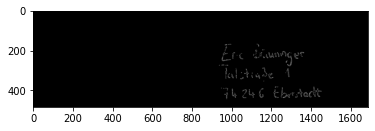

In [595]:
th, binAF = cv2.threshold(addressField, 128, 255, cv2.THRESH_BINARY)
plt.imshow(binAF,cmap="gray")

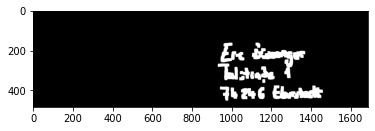

In [603]:
dilateChar = cv2.dilate(binAF,characterDK,iterations=1)
plt.imshow(dilateChar,cmap="gray")

In [597]:
# erodeChar = cv2.erode(dilateChar,characterEK,iterations=1)
# plt.imshow(dilateChar,cmap="gray")

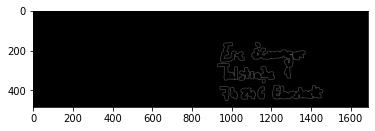

In [598]:
cannyChar = cv2.Canny(dilateChar,0,30)
plt.imshow(cannyChar,cmap="gray")

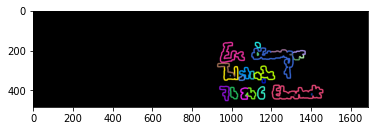

In [599]:
imgAF,contoursAF,hierachyAF = cv2.findContours(cannyChar,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
heightAF,widthAF = addressField.shape
plt.imshow(imgAF,cmap="gray")
contourImg = np.zeros((heightAF,widthAF,3))
for index,contour in enumerate(contoursAF):
    r = random.random()
    g = random.random()
    b = random.random()
    cv2.drawContours(contourImg,contoursAF , index, (r,g,b), 5) 
plt.imshow(contourImg)

## Display Function
https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

In [600]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## Extract the Characters

In [601]:
print(hierachyAF[0][4])

[ 5  3 -1 -1]


In [602]:
characters = []
for index,contour in enumerate(contoursAF):
    # [x,y,width,height]
    rect = cv2.boundingRect(contour)
    x = rect[0]
    y = rect[1]
    width = rect[2]
    height = rect[3]
    # 0 because of the outer
    if(width>5 and height>5 and width!=widthAF and hierachyAF[0][index][3]==0):
        img = binAF[y:y+height,x:x+width]
        character = {
                "img": img,
                "width" : width,
                "height" : height,
                "x" : x,
                "y": y
                }
        characters.append(character)
        # plt.imshow(character,cmap="gray")
show_images(pydash.map_(characters,"img")) 

ValueError: figure size must be positive finite not [0. 0.]

In [557]:
centerPoints = characters
print(pydash.map_(characters,["x"]))
print(pydash.map_(characters,["y"]))

[1256]
[418]


In [558]:
mean_width = np.sum(pydash.map_(characters,"width"))/len(characters)
mean_height = np.sum(pydash.map_(characters,"height"))/len(characters)
def sortY(element):
    return element["y"]
centerPoints.sort(key=sortY)
print(mean_width)
print(mean_height)
print(pydash.map_(characters,["x"]))
print(pydash.map_(characters,["y"]))

14.0
12.0
[1256]
[418]


## Get the Rowedges

[[417.5, 418.5]]
[1.]


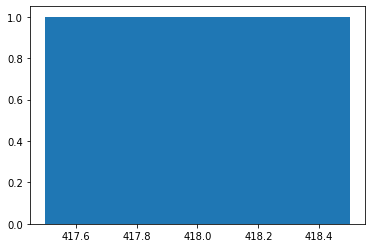

In [559]:
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
amount, binEdges, _  = plt.hist(pydash.map_(characters,["y"]), bins="auto")
rowEdges = []
for i,yValue in enumerate(amount):
    if(yValue>0):
        rowEdges.append([binEdges[i],binEdges[i+1]])


print(rowEdges)
print(amount)

## Get the Rows

In [560]:
rows = []
lastChar = characters[len(characters)-1]
for edge in rowEdges:
    rowElements = []
    for index,character in enumerate(characters):
        if(edge[0]<=character["y"]): 
            if(edge[1]>=character["y"]):
                rowElements.append(character)
                # for last Edge that the rowElements are added
                if(lastChar==character):
                    rows.append(rowElements)
            else:
                rows.append(rowElements)
                break
print(len(rows))

1


## Displaying the Rows

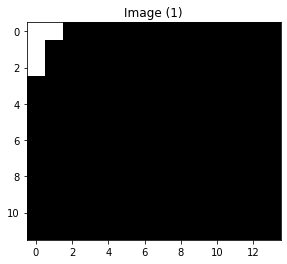

In [561]:
def sortX(element):
    return element["x"]

for row in rows:
    row.sort(key=sortX)
    show_images(pydash.map_(row,"img")) 

## Get PLZ
From Last Row

https://www.sekretaria.de/bueroorganisation/korrespondenz/din-5008/anschrift/

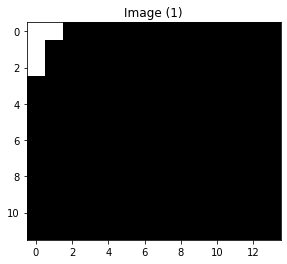

In [562]:
lastRow = rows[len(rows)-1]
PLZ = lastRow[0:5]
show_images(pydash.map_(PLZ,"img"))

### Bekomme den Stream der Kamera und verwandle es in ein grau Stufen Bild
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html?highlight=video

In [563]:
# cap = cv2.VideoCapture(0)

# while(True):
#     # Capture frame-by-frame
#     ret, frame = cap.read()

#     # Our operations on the frame come here
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html?highlight=imshow
#     #canny Edge Detection
#     edges = cv2.Canny(gray,100,200)
#     # 1 Fenster mit Graustufe
#     namedWindow1 = "gray"
#     cv2.namedWindow(namedWindow1)
#     cv2.moveWindow(namedWindow1,0,0)
#     cv2.imshow(namedWindow1, gray)
#     # 2 Fenster mit Kantenbild
#     namedWindow2 = "edges"
#     cv2.namedWindow(namedWindow2)
#     cv2.moveWindow(namedWindow2,640,0)
#     cv2.imshow(namedWindow2,edges)
#     # 3 Fenster 
#     namedWindow3 = "weiteres"
#     cv2.namedWindow(namedWindow3)
#     cv2.moveWindow(namedWindow3,1280,0)
#     cv2.imshow(namedWindow3,edges)


#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()

In [564]:
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Neural Network

In [565]:
# dataset_folder = os.path.abspath("./emnist_dataset")
# print(dataset_folder)

In [566]:
# class CrvModel:
#     def __init__(self, dataset_folder):
        
#         # Constatns and Paths for Networks
#         self.dataset_path = dataset_folder
#         self.emnist_classes = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
#         self.num_emnist_classes = len(self.emnist_classes)
#         self.mnist_classes = "0123456789"
#         self.num_mnist_classes = len(self.mnist_classes)
#         self.emnist_letter_classes = "-abcdefghijklmnopqrstuvwxyz"
#         self.num_emnist_letter_classes = len(self.emnist_letter_classes)

#         print(self.num_emnist_letter_classes)
        
#         # Constants for training and paths to save models
#         self.batch_size = 1024
#         self.epochs = 100
#         self.emnist_save_path = "./emnist_byclass.h5"
#         self.emnist_letter_save_path = "./emnist_letter.h5"
#         self.mnist_save_path = "./mnist.h5"

#         # Read in or download raw data for models
#         self.raw_emnist_train_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-train-images-idx3-ubyte.gz'))
#         self.raw_emnist_train_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-train-labels-idx1-ubyte.gz'))
#         self.raw_emnist_test_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-test-images-idx3-ubyte.gz'))
#         self.raw_emnist_test_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-byclass-test-labels-idx1-ubyte.gz'))

#         self.raw_emnist_letter_train_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-train-images-idx3-ubyte.gz'))
#         self.raw_emnist_letter_train_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-train-labels-idx1-ubyte.gz'))
#         self.raw_emnist_letter_test_img = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-test-images-idx3-ubyte.gz'))
#         self.raw_emnist_letter_test_labels = self.read_local_data(os.path.join(dataset_folder, 'emnist-letters-test-labels-idx1-ubyte.gz'))

#         (self.raw_mnist_train_img, self.raw_mnist_train_labels), (self.raw_mnist_test_img, self.raw_mnist_test_labels) = tf.keras.datasets.mnist.load_data()
        
#         # Preprocess data
#         self.emnist_train_img = self.preprocess_data(self.raw_emnist_train_img)
#         self.emnist_test_img = self.preprocess_data(self.raw_emnist_test_img)
#         self.emnist_train_labels = tf.keras.utils.to_categorical(self.raw_emnist_train_labels)
#         self.emnist_test_labels = tf.keras.utils.to_categorical(self.raw_emnist_test_labels)
        
#         self.mnist_train_img = self.preprocess_data(self.raw_mnist_train_img)
#         self.mnist_test_img = self.preprocess_data(self.raw_mnist_test_img)
#         self.mnist_train_labels = tf.keras.utils.to_categorical(self.raw_mnist_train_labels)
#         self.mnist_test_labels = tf.keras.utils.to_categorical(self.raw_mnist_test_labels)

#         self.emnist_letter_train_img = self.preprocess_data(self.raw_emnist_letter_train_img)
#         self.emnist_letter_test_img = self.preprocess_data(self.raw_emnist_letter_test_img)
#         self.emnist_letter_train_labels = tf.keras.utils.to_categorical(self.raw_emnist_letter_train_labels)
#         self.emnist_letter_test_labels = tf.keras.utils.to_categorical(self.raw_emnist_letter_test_labels)

#         # Earlystopping Callback
#         self.early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
#                                                                     min_delta=0.002,
#                                                                     patience=5,
#                                                                     verbose = 1,
#                                                                     restore_best_weights=True)

#         # Setup network architecture
#         self.emnist_cnn = self.setup_network(self.num_emnist_classes)
#         self.emnist_letter_cnn = self.setup_network(self.num_emnist_letter_classes)
#         self.mnist_cnn = self.setup_network(self.num_mnist_classes)


    
#     # Function Definitions
#     def load_mnist_digits(self):
#         print("Lade MNIST Datenset")
        
#     def read_local_data(self, path):
#         print("Lese Datenset '%s' ein" %path)
#         with gzip.open(path, "rb") as f:
#             z, dtype, dim = struct.unpack(">HBB", f.read(4))
#             print("Dimensions:", dim)
#             shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dim))
#             print("Shape:", shape)
#             print("***********************************************")
#             return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
        
#     def show_random_image(self, data_imgs, classes, data_labels):
#         i = random.randint(0, data_imgs.shape[0])
#         fig, ax = plt.subplots()
#         ax.clear()
#         ax.imshow(data_imgs[i].T, cmap="gray")
#         title = "label = %d = %s" %(data_labels[i], classes[data_labels[i]])
#         ax.set_title(title, fontsize=20)
#         plt.show()
        
#     def preprocess_data(self, raw_data):
#         normalized_data = raw_data.astype("float32")/255
#         reshaped_data = normalized_data.reshape(normalized_data.shape[0], 28, 28, 1)
#         return reshaped_data

#     def setup_network(self, num_classes):
#         model = tf.keras.models.Sequential()
#         model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
#         model.add(tf.keras.layers.BatchNormalization())
#         model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu'))
#         model.add(tf.keras.layers.BatchNormalization())
#         model.add(tf.keras.layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
#         model.add(tf.keras.layers.BatchNormalization())
#         model.add(tf.keras.layers.Dropout(0.25))
#         model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
#         model.add(tf.keras.layers.BatchNormalization())
#         model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
#         model.add(tf.keras.layers.BatchNormalization())
#         model.add(tf.keras.layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
#         model.add(tf.keras.layers.BatchNormalization())
#         model.add(tf.keras.layers.Dropout(0.25))
#         model.add(tf.keras.layers.Conv2D(128, kernel_size = 4, activation='relu'))
#         model.add(tf.keras.layers.BatchNormalization())
#         model.add(tf.keras.layers.Flatten())
#         model.add(tf.keras.layers.Dropout(0.4))
#         model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        
#         return model
        

## Model initialisieren

In [567]:
# model = CrvModel(dataset_folder)

In [568]:
# model.show_random_image(model.raw_emnist_train_img, model.emnist_classes, model.raw_emnist_train_labels)
# model.show_random_image(model.raw_mnist_train_img, model.mnist_classes, model.raw_mnist_train_labels)
# model.show_random_image(model.raw_emnist_letter_train_img, model.emnist_letter_classes, model.raw_emnist_letter_train_labels)

In [569]:
# print("-----------------------------------------------------------------------------")
# print("Full Emnist Neural Network")

# model.emnist_cnn.summary()
# model.emnist_cnn.compile(loss = "categorical_crossentropy",
#                          optimizer = "adam",
#                          metrics = ["accuracy"],
#                          callbacks = [model.early_stopping_callback])

# print("-----------------------------------------------------------------------------")
# print("Emnist Letter Neural Network")
# model.emnist_letter_cnn.summary()
# model.emnist_letter_cnn.compile(loss = "categorical_crossentropy",
#                          optimizer = "adam",
#                          metrics = ["accuracy"],
#                          callbacks = [model.early_stopping_callback])

# print("-----------------------------------------------------------------------------")
# print("Mnist Neural Network")
# model.mnist_cnn.summary()
# model.mnist_cnn.compile(loss = "categorical_crossentropy", 
#                         optimizer = "adam",
#                         metrics = ["accuracy"])

In [570]:
'''
print("*******************************************************************")
print("Train Emnist Model")
print("*******************************************************************")

model.emnist_trained = model.emnist_cnn.fit(model.emnist_train_img,
              model.emnist_train_labels,
              batch_size = model.batch_size,
              epochs = model.epochs,
              verbose = 1,
              validation_data = (model.emnist_test_img, model.emnist_test_labels),
               callbacks = [model.early_stopping_callback])

model.emnist_cnn.save(model.emnist_save_path)

print("*******************************************************************")
print("Train Emnist Letter Model")
print("*******************************************************************")

model.emnist_letter_trained = model.emnist_letter_cnn.fit(model.emnist_letter_train_img,
              model.emnist_letter_train_labels,
              batch_size = model.batch_size,
              epochs = model.epochs,
              verbose = 1,
              validation_data = (model.emnist_letter_test_img, model.emnist_letter_test_labels),
              callbacks = [model.early_stopping_callback])

model.emnist_letter_cnn.save(model.emnist_letter_save_path)


print("*******************************************************************")
print("Train Mnist Letter Model")
print("*******************************************************************")

model.mnist_trained = model.mnist_cnn.fit(model.mnist_train_img,
                                    model.mnist_train_labels,
                                    batch_size = model.batch_size,
                                    epochs = model.epochs,
                                    verbose = 1,
                                    validation_data = (model.mnist_test_img, model.mnist_test_labels),
                                    callbacks = [model.early_stopping_callback])

model.mnist_cnn.save(model.mnist_save_path)
'''

# model.emnist_cnn.load_weights(model.emnist_save_path)
# model.emnist_letter_cnn.load_weights(model.emnist_letter_save_path)
# model.mnist_cnn.load_weights(model.mnist_save_path)

'\nprint("*******************************************************************")\nprint("Train Emnist Model")\nprint("*******************************************************************")\n\nmodel.emnist_trained = model.emnist_cnn.fit(model.emnist_train_img,\n              model.emnist_train_labels,\n              batch_size = model.batch_size,\n              epochs = model.epochs,\n              verbose = 1,\n              validation_data = (model.emnist_test_img, model.emnist_test_labels),\n               callbacks = [model.early_stopping_callback])\n\nmodel.emnist_cnn.save(model.emnist_save_path)\n\nprint("*******************************************************************")\nprint("Train Emnist Letter Model")\nprint("*******************************************************************")\n\nmodel.emnist_letter_trained = model.emnist_letter_cnn.fit(model.emnist_letter_train_img,\n              model.emnist_letter_train_labels,\n              batch_size = model.batch_size,\n            

In [571]:
'''
print("Emnist Full Network")
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(model.emnist_trained.history['loss'])
plt.plot(model.emnist_trained.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(model.emnist_trained.history['accuracy'])
plt.plot(model.emnist_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Emnist Letter Network")
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(model.emnist_letter_trained.history['loss'])
plt.plot(model.emnist_letter_trained.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(model.emnist_trained.history['accuracy'])
plt.plot(model.emnist_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("Mnist Network")
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(model.mnist_trained.history['loss'])
plt.plot(model.mnist_trained.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(model.mnist_trained.history['accuracy'])
plt.plot(model.mnist_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
'''

'\nprint("Emnist Full Network")\nplt.figure()\nplt.subplot(1, 2, 1)\nplt.plot(model.emnist_trained.history[\'loss\'])\nplt.plot(model.emnist_trained.history[\'val_loss\'])\nplt.title(\'Model Loss\')\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Loss\')\nplt.legend([\'train\', \'test\'], loc=\'upper left\')\nplt.subplot(1, 2, 2)\nplt.plot(model.emnist_trained.history[\'accuracy\'])\nplt.plot(model.emnist_trained.history[\'val_accuracy\'])\nplt.title(\'Model Accuracy\')\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Accuracy\')\nplt.legend([\'train\', \'test\'], loc=\'upper left\')\nplt.show()\n\nprint("Emnist Letter Network")\nplt.figure()\nplt.subplot(1, 2, 1)\nplt.plot(model.emnist_letter_trained.history[\'loss\'])\nplt.plot(model.emnist_letter_trained.history[\'val_loss\'])\nplt.title(\'Model Loss\')\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Loss\')\nplt.legend([\'train\', \'test\'], loc=\'upper left\')\nplt.subplot(1, 2, 2)\nplt.plot(model.emnist_trained.history[\'accuracy\'])\nplt.plot(model.emnist_traine

In [572]:
# emnist_results = model.emnist_cnn.evaluate(model.emnist_test_img, model.emnist_test_labels, verbose=0)
# emnist_letter_results = model.emnist_letter_cnn.evaluate(model.emnist_letter_test_img, model.emnist_letter_test_labels, verbose=0)
# mnist_results = model.mnist_cnn.evaluate(model.mnist_test_img, model.mnist_test_labels, verbose=0)
# print('Emnist Loss: %.2f%%, Accuracy: %.2f%%' % (emnist_results[0]*100, emnist_results[1]*100))
# print('Emnist Letter Loss: %.2f%%, Accuracy: %.2f%%' % (emnist_letter_results[0]*100, emnist_letter_results[1]*100))
# print('Mnist Loss: %.2f%%, Accuracy: %.2f%%' % (mnist_results[0]*100, mnist_results[1]*100))

# Abgleich mit Datenbank

In [573]:
# def get_town(plz):
#     # Verbindung, Cursor
#     connection = sqlite3.connect("orteDE.db")
#     cursor = connection.cursor()

#     # SQL-Abfrage
#     sql = "SELECT ortsname, bundesland FROM orte WHERE plz="+str(plz)

#     # Kontrollausgabe der SQL-Abfrage
#     # print(sql) 

#     # Absenden der SQL-Abfrage
#     # Empfang des Ergebnisses
#     cursor.execute(sql)

#     # Ausgabe des Ergebnisses
#     results = cursor.fetchall()
#     #for dsatz in cursor:
#     #    ort = dsatz[0]
#     #    bundesland = dsatz[1]
        
#     # Verbindung beenden
#     connection.close()

#     return results

In [574]:
# #Example for single PLZ
# print(get_town(74246))
# #Example for multiple PLZ
# print(get_town(27367))